
# Seis2Rock - Synthetic Dataset <br> 
## Petrophysical Inversion on Synthetic 2D profile constructed from the Reservoir Model of the Smeaheia Field.



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import pylops
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from scipy.ndimage import gaussian_filter

from seis2rock.seis2rock_functions import *
from seis2rock.seis2rock_utils import *

from seis2rock.pem_seis2rock import pem_seis2rock

import pandas as pd

np.random.seed(5)

## Loading and visualizing data needed

In [2]:
f = np.load('../../data/smeaheia_synthetic.npz', 
            allow_pickle=True) 

f.files

['phi', 'vsh', 'sw', 'sw_displaced', 'depth', 'x_axis']

In [3]:
phi_2D = f['phi']
vsh_2D = f['vsh']
sw_2D = f['sw']
sw_displaced_2D = f['sw_displaced']
depth = f['depth']
x_axis = f['x_axis']

Let's see the petrophysical properties of the 2D section

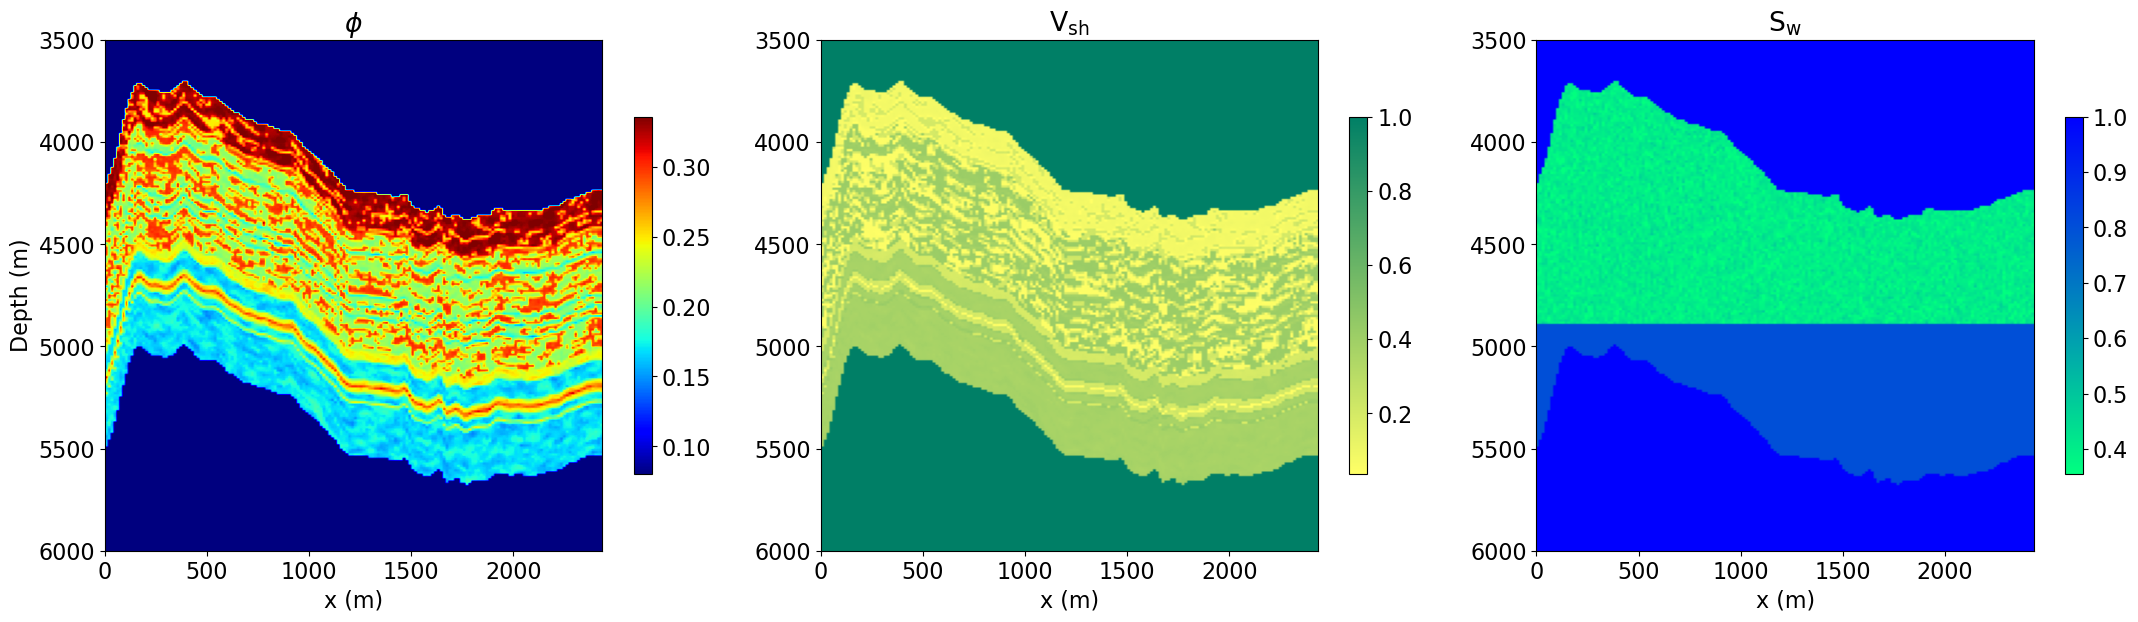

In [4]:
fig = plot_petrophysical_2D_sections(phi_2D, vsh_2D, sw_2D, x_axis, depth, fontsize=16)

Also, we need to get the background models

In [5]:
phi_2D_back, vsh_2D_back, sw_2D_back = create_background_models_synthetic(phi=phi_2D , 
                                                                          vsh=vsh_2D , 
                                                                          sw=sw_2D , 
                                                                          nsmooth=15)

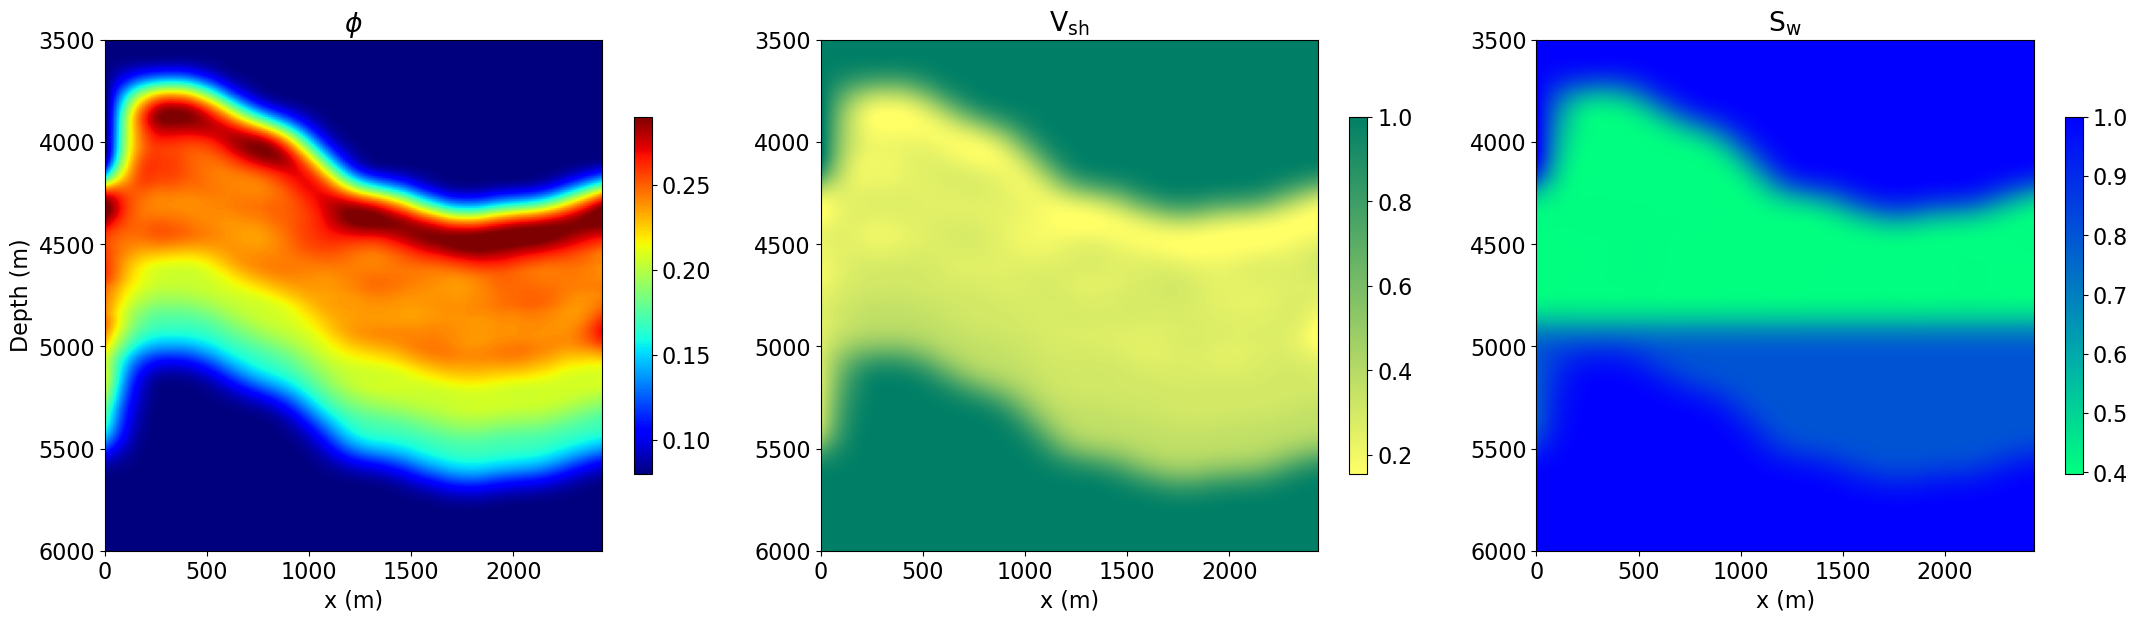

In [6]:
fig = plot_petrophysical_2D_sections(phi_2D=phi_2D_back, 
                                     vsh_2D=vsh_2D_back, 
                                     sw_2D=sw_2D_back, 
                                     x_axis=x_axis, 
                                     depth=depth, 
                                     fontsize=16)

## Rock Physics Model

Appliying Rock Physics Model for the petrophysical properties and their background models

In [7]:
vp_2D, vs_2D, rho_2D = pem_seis2rock(phi=phi_2D, vsh=vsh_2D, sw=sw_2D,
                          pres=2.41e7, temp=50, sal=10000,
                          oilgrav=20, gasgrav=0.9, gor=160)

vp_2D_back, vs_2D_back, rho_2D_back = pem_seis2rock(phi=phi_2D_back, vsh=vsh_2D_back, sw=sw_2D_back,
                          pres=2.41e7, temp=50, sal=10000,
                          oilgrav=20, gasgrav=0.9, gor=160)

Plot of the elastic properties

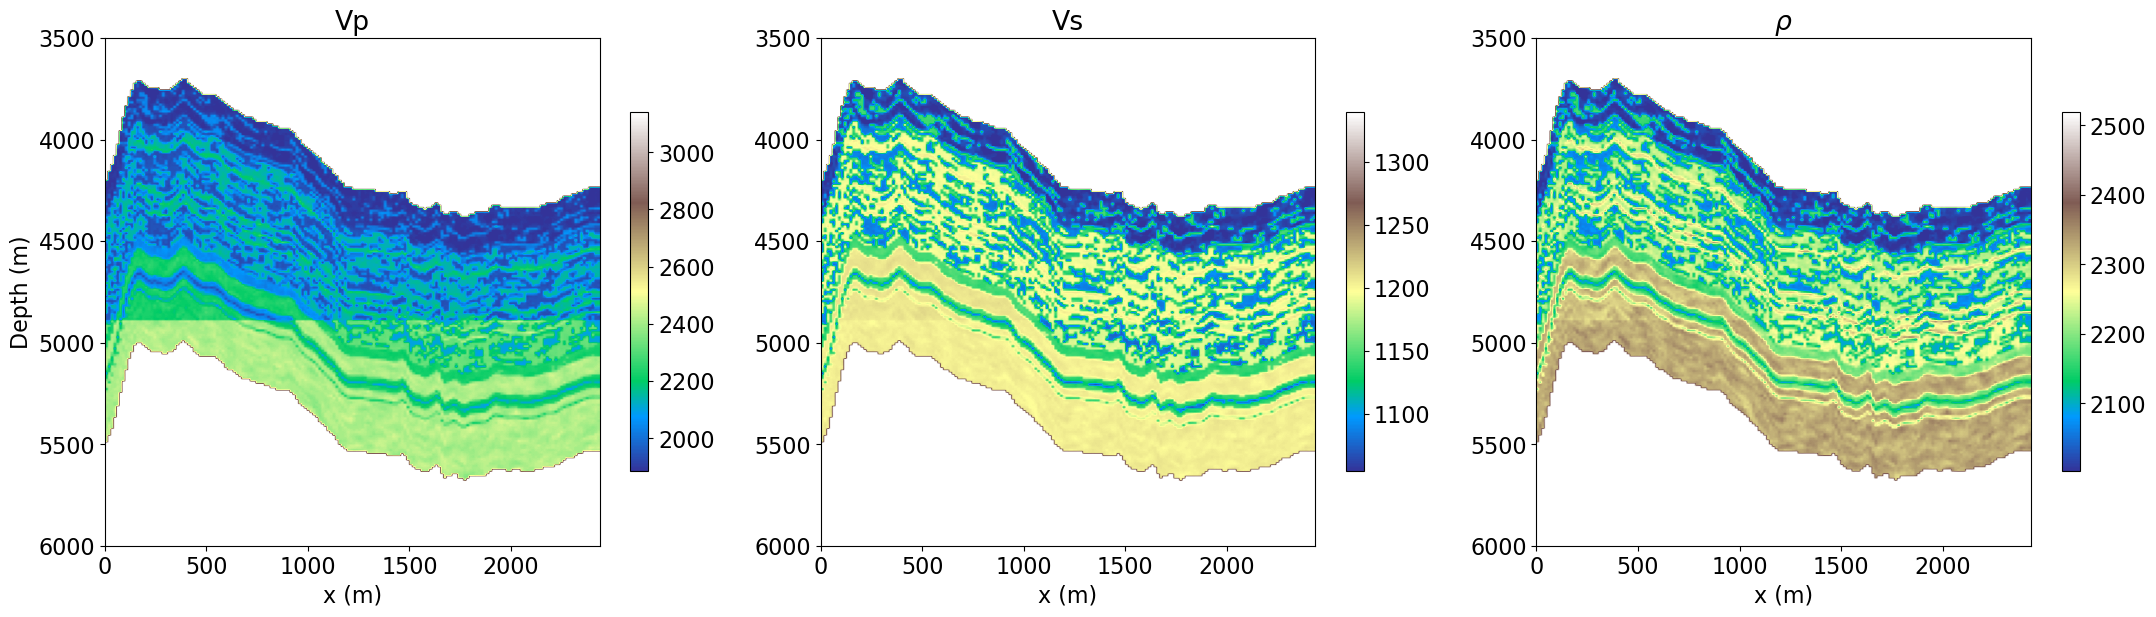

In [8]:
fig = plot_elastic_2D_sections(vp_2D=vp_2D, vs_2D=vs_2D, rho_2D=rho_2D,
                               x_axis=x_axis, depth=depth, fontsize=16)

Plot of the background elastic properties

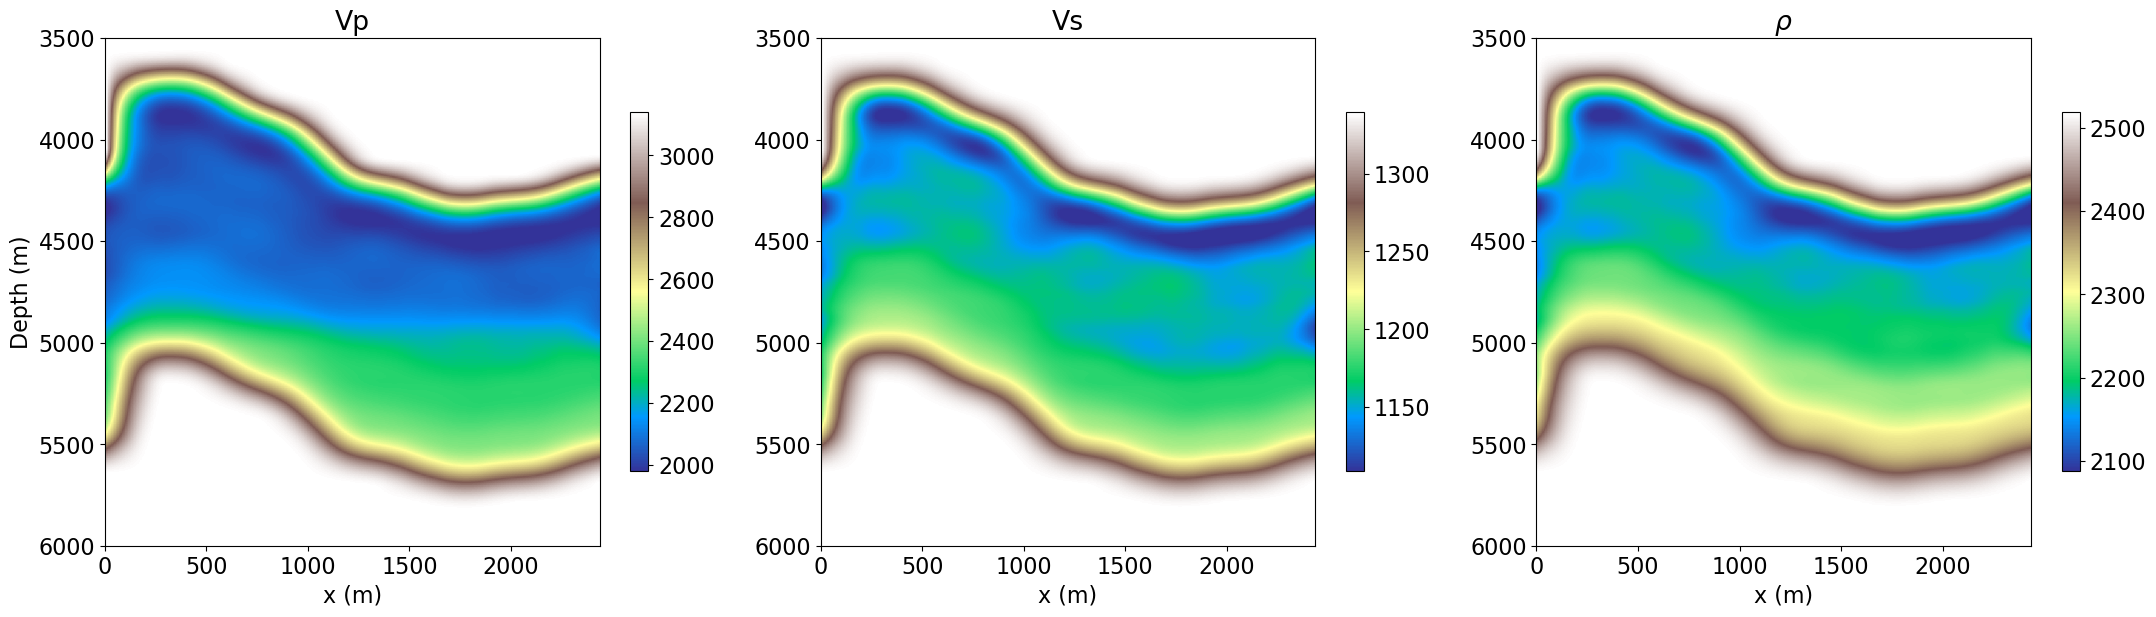

In [9]:
fig = plot_elastic_2D_sections(vp_2D=vp_2D_back, vs_2D=vs_2D_back, rho_2D=rho_2D_back,
                               x_axis=x_axis, depth=depth, fontsize=16)

### AVO synthetic gather

Here we will create the AVO gathers using the non-linear Zoeppritz equation, but first we need to create the wavelet

In [10]:
#Define the time/depth axis
ntime = depth.shape[0]
timemin, timemax = 0, depth.shape[0]**0.006
timeax = np.linspace(timemin, timemax, ntime)

# Convolve 1D
ntwav = 41
wav, th, hcenter = ricker(timeax[:ntwav//2+1], f0=20)

In [11]:
thetamin=1
thetamax=45
ntheta=45

d = avo_synthetic_gather_2D(vp=vp_2D.T, vs=vs_2D.T, rho=rho_2D.T, wav_est=wav, 
                            nt_wav=hcenter, thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

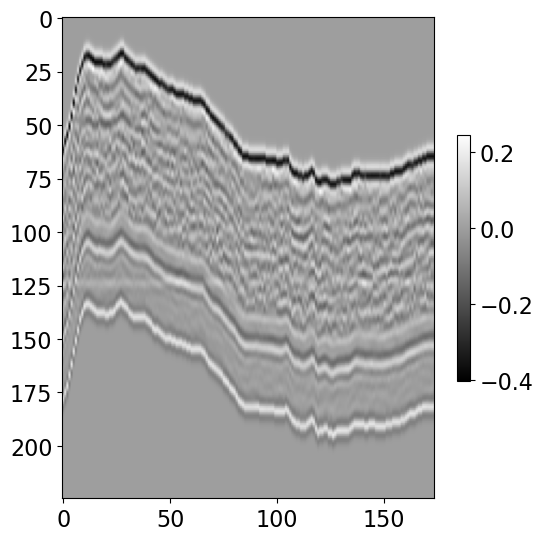

In [12]:
plt.figure(figsize=(6, 8))
plt.imshow(d[:,:,0].T, cmap='gray')
plt.colorbar(shrink=0.4)

### Well-log information

For this notebook we will assume we have information to a well and its well log information at the profile x = 1408 m or index 100

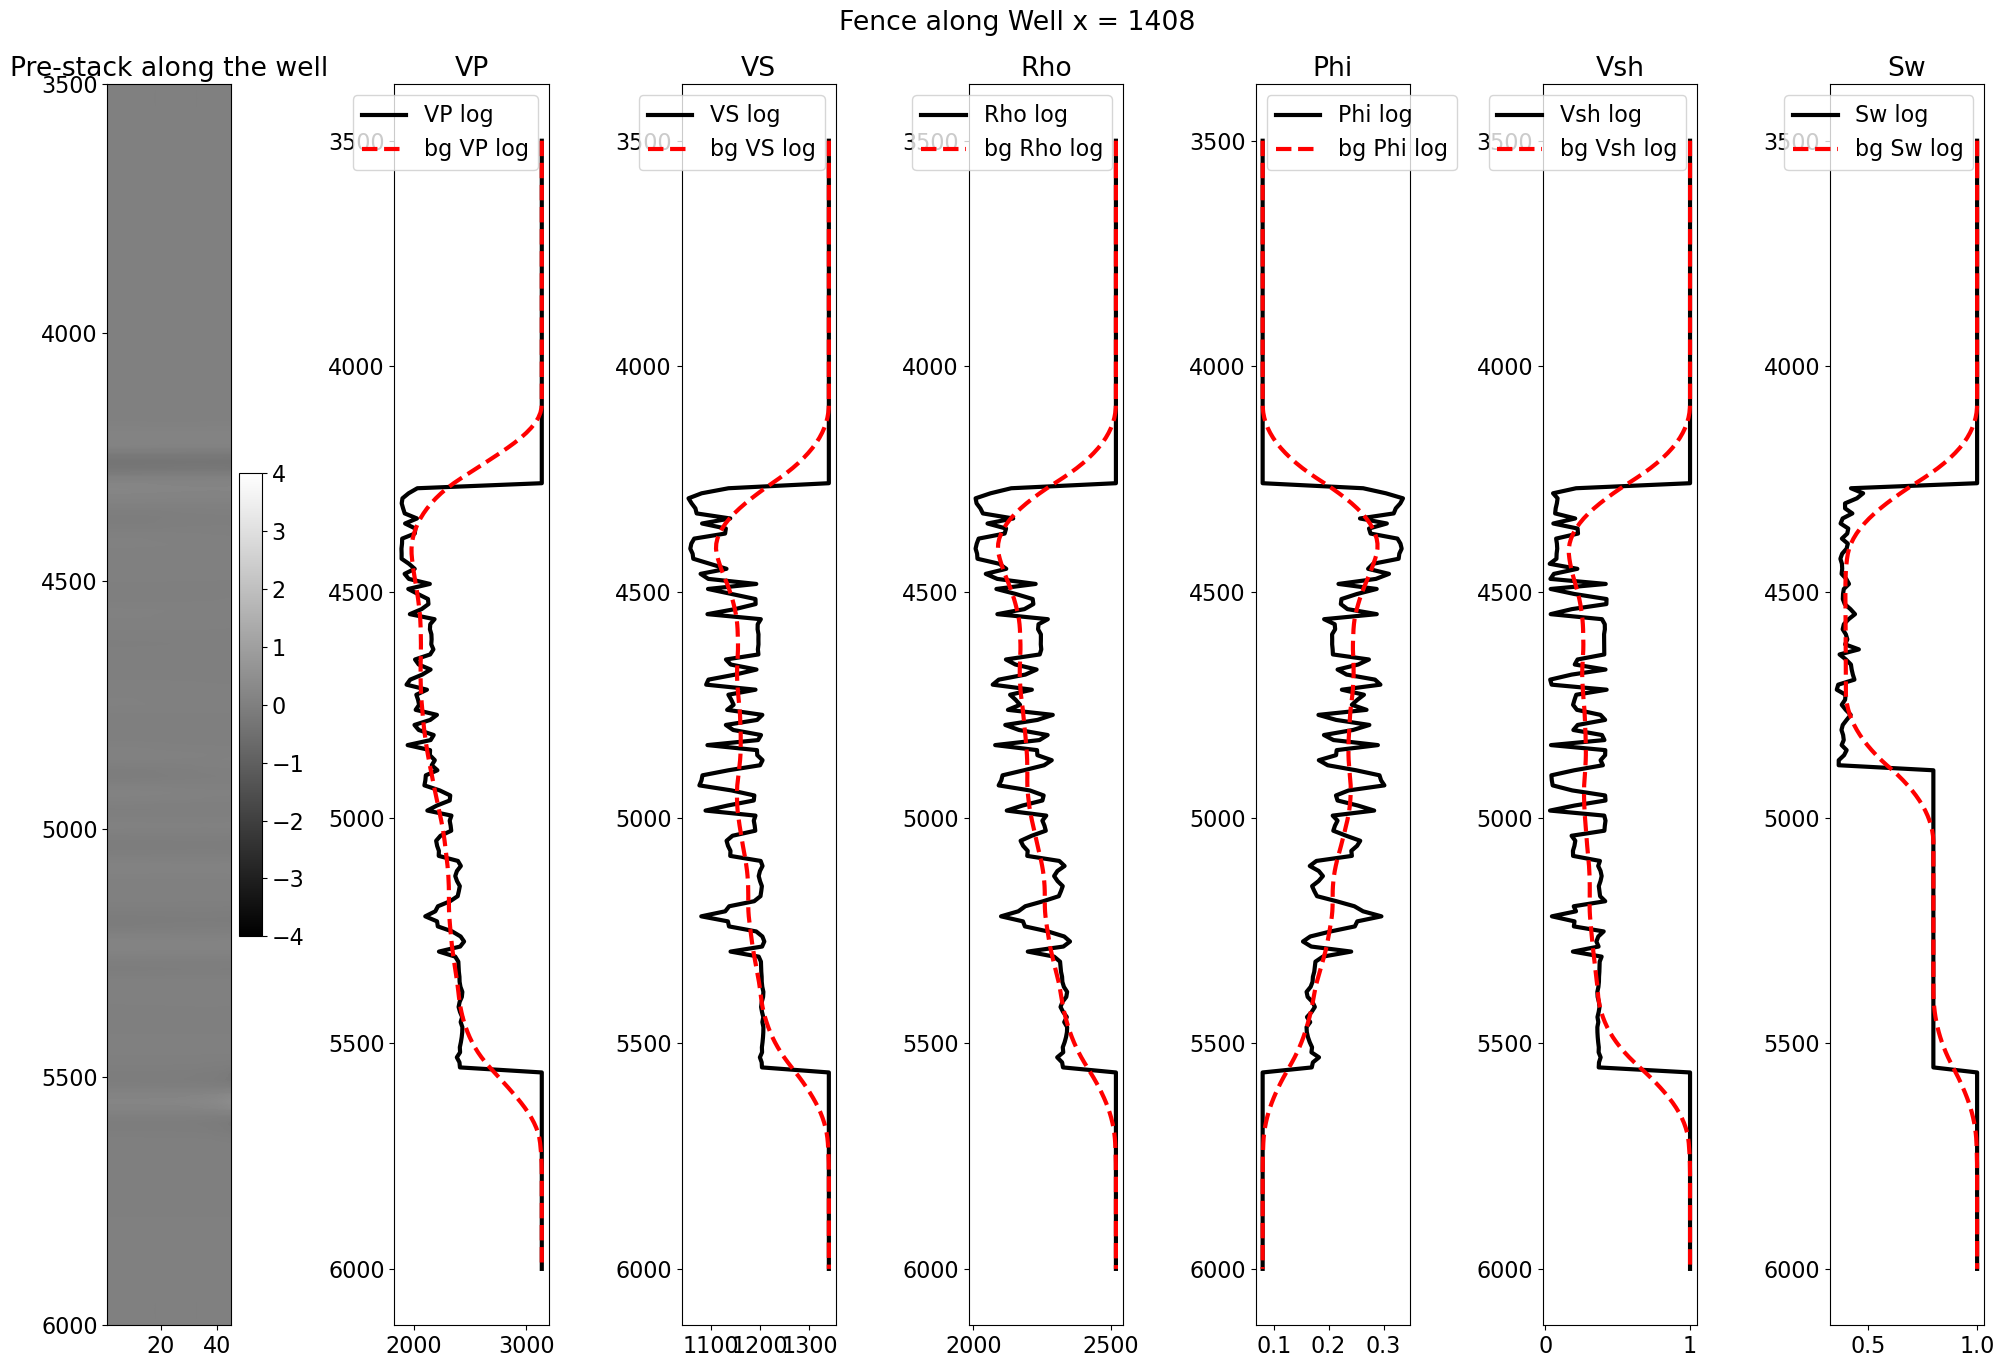

In [13]:
x_loc = 100

#Well logs
vp, vs, rho, phi, vsh, sw = extract_well_logs_from_2D(vp_2D=vp_2D, vs_2D=vs_2D, rho_2D=rho_2D,
                                                      phi_2D=phi_2D, vsh_2D=vsh_2D, sw_2D=sw_2D, 
                                                      x_loc=x_loc)
#Background logs
vp_back, vs_back, rho_back, phi_back, vsh_back, sw_back = extract_well_logs_from_2D(vp_2D=vp_2D_back, vs_2D=vs_2D_back, rho_2D=rho_2D_back,
                                                                                    phi_2D=phi_2D_back, vsh_2D=vsh_2D_back, sw_2D=sw_2D_back, 
                                                                                    x_loc=x_loc)

plot_set_logs(well_name='Fence along Well x = 1408', 
              well_prestack=d[x_loc,:,:], 
              extent_prestack=(thetamin, thetamax, depth[-1], depth[0]), 
              well_depth=depth,
              vp=vp, 
              vs=vs, 
              rho=rho, 
              phi=phi, 
              vsh=vsh, 
              sw=sw,
              vp_back=vp_back, 
              vs_back=vs_back, 
              rho_back=rho_back,
              phi_back=phi_back, 
              vsh_back=vsh_back, 
              sw_back=sw_back, 
              figsize=(20,14))

## Seis2Rock framework

Now, we come to the most exciting part, where we apply the proposed methodology. We begin with the training phase, and it's important to note that we are not training any neural network in this context. The term "training" refers to obtaining the optimal basis functions $\mathrm{Fp}$ learned from the AVO synthetic gather.

In [14]:
# Select number of p optimal coeffcients 
p = 5
Fp, Lp, Vp, F, L, V, r_zoeppritz, r_zoeppritz_back, d_well = Seis2Rock_training(vp=vp, vs=vs, rho=rho, 
                                                                      wav_est=wav, nt_wav=hcenter, 
                                                                      vp_back=vp_back, vs_back=vs_back, rho_back=rho_back, 
                                                                      p=p, 
                                                                      thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

Computing AVO synthetic gathers from the well logs...
Performing SVD...
Extracting Optimal basis functions Fp..
Done! xD


Just to double check, let us look at the singular values

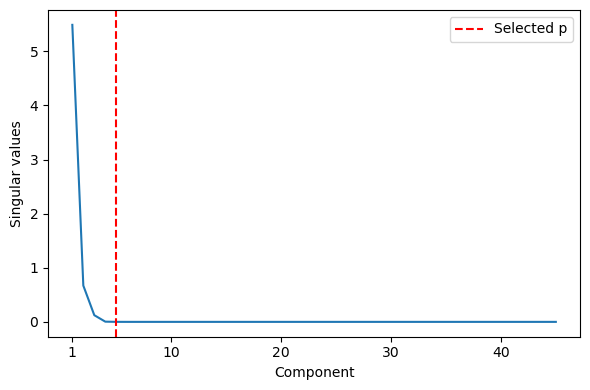

In [31]:
# plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(L) + 1), np.diag(np.abs(L)))
plt.xlabel('Component')
plt.ylabel('Singular values')
plt.axvline(x=p, color='r', linestyle='--', label='Selected p')
plt.axis('tight')
# plt.xticks([1, 10, 20, 30, 40])
plt.legend()
plt.tight_layout()
# plt.savefig('../../figures_results/singular_values.png', format='png', dpi=300)

plt.show()

Now, we move on to the inference phase, where we obtain the optimal coefficients $\mathrm{Cp}$ and, consequently, the new data term $\mathrm{B}$, which represents the petrophysical reflectivities.

In [16]:
b_optAVO, r_zoeppritz_back, Cp, Hp, Cp_estimated = Seis2Rock_inference(vp=vp_2D_back.T, vs=vs_2D_back.T, rho=rho_2D_back.T, 
                                                         wav_est=wav, nt_wav=hcenter, dtheta=d.transpose(0,2,1), 
                                                         Fp=Fp, Lp=Lp, Vp=Vp, 
                                                         phi=phi, vsh=vsh, sw=sw, 
                                                         phi_back=phi_back, vsh_back=vsh_back, sw_back=sw_back,
                                                         d=d_well, 
                                                         thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

Computing AVO synthetic gather for background models...
Calculating matrix of optimal coefficients Cp...
Creating the new data term (Petrophysical coefficeints B)...
Done xD !


Now, we just need to perform the series of poststack seismic inversion per parameter. Here our new data term to invert for is $\mathrm{B}$

In [17]:
## Series of poststack seismic inversion (one per parameter)
## Here we use B as our 'new data term' which is the petrophysical coefficients

## Creating Post Stack Operator
kind = 'forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO.shape[1],  b_optAVO.shape[2]], dtype='float64')



## Hyperparameters for optimization
niter = 50
lamba1 = np.sqrt(1e-2)
damp1 = 10e-2

lamba2 = np.sqrt(1e-1)
damp2 = 1e-2

lamba3=np.sqrt(2e-2)
damp3 = 10e0

## Inverting for porosity
phi_inv_dense_reg = regularized_inversion(D, b_optAVO[0].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(phi_2D_back[:,:].ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(phi_2D_back[:,:].shape) 

## Inverting for vsh
vsh_inv_dense_reg = regularized_inversion(D, b_optAVO[1].ravel(), Regs=[D2op],
                                    epsRs=[lamba2],x0=(vsh_2D_back[:,:].ravel()),
                                    **dict(iter_lim=niter, damp=damp2))[0].reshape(vsh_2D_back[:,:].shape) 

## Inverting for sw
sw_inv_dense_reg = regularized_inversion(D, b_optAVO[2].ravel(), Regs=[D2op],
                                    epsRs=[lamba2],x0=sw_2D_back[:,:].ravel(),
                                    **dict(iter_lim=50, damp=damp2))[0].reshape(sw_2D_back[:,:].shape) 


Inversion results on the 2D profile

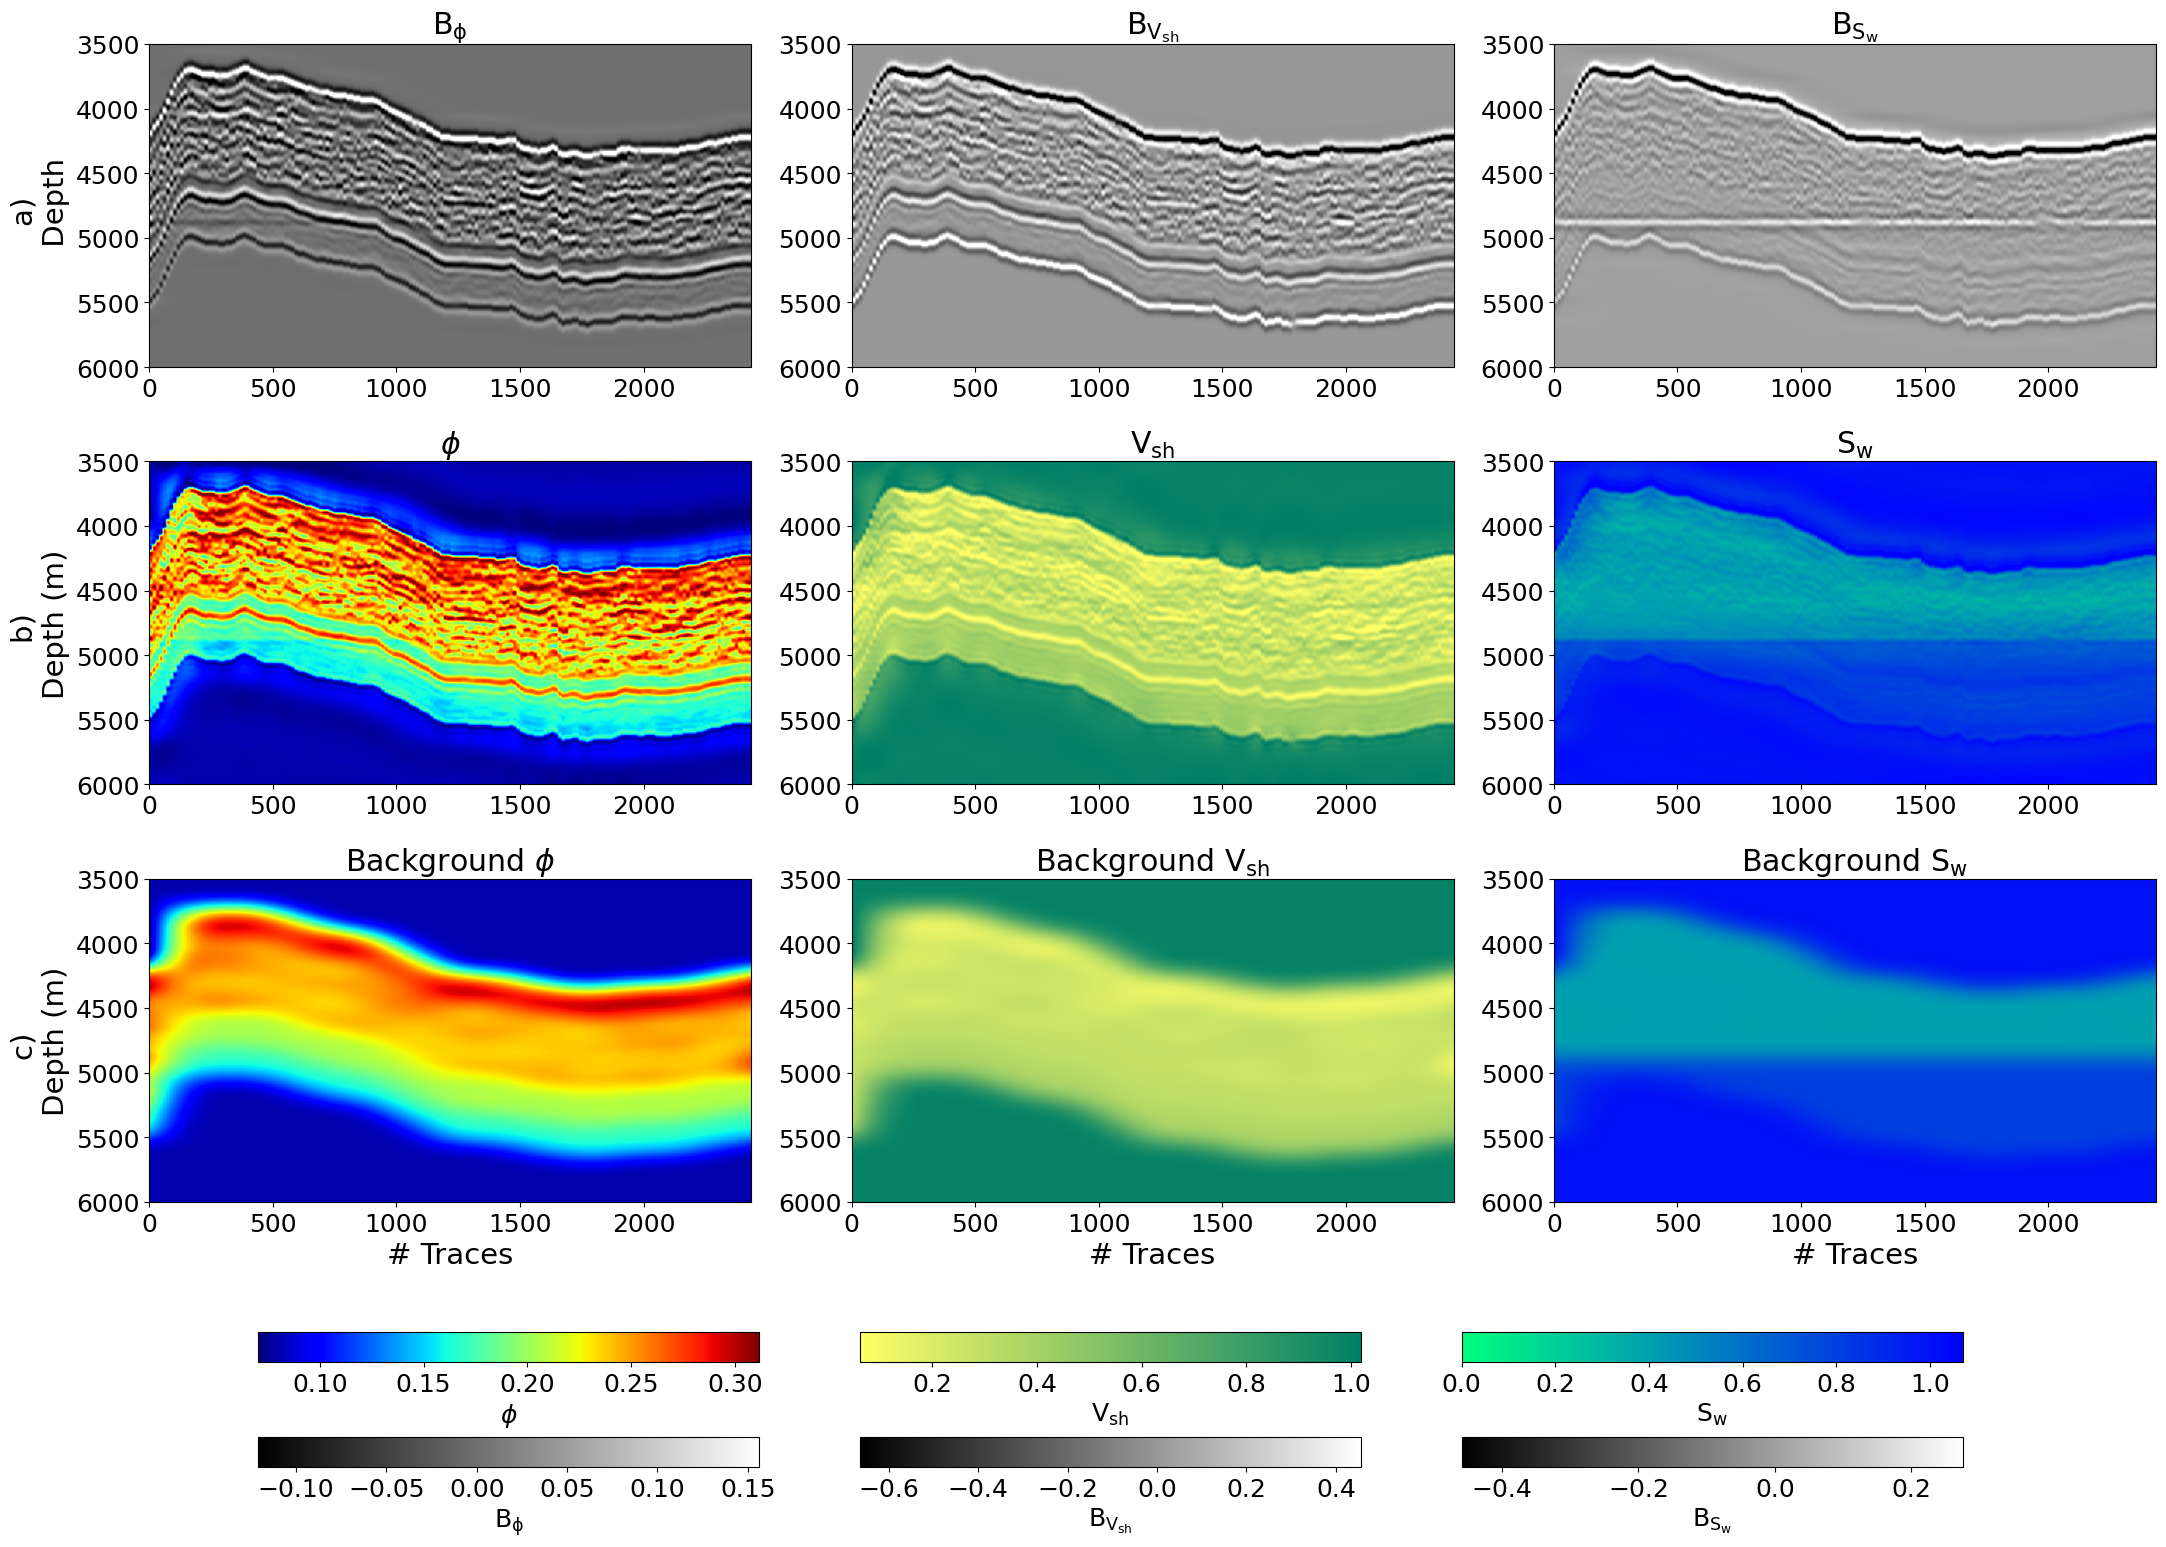

In [18]:
fig = plot_inversion_results_2D(wellname='x=140', depth=depth, x_axis=x_axis,
                                   phi_inv_dense_reg=phi_inv_dense_reg, 
                                   vsh_inv_dense_reg=vsh_inv_dense_reg, 
                                   sw_inv_dense_reg=sw_inv_dense_reg, 
                                   b_optAVO=b_optAVO,
                                   phi_fence_bg=phi_2D_back.T, 
                                   vsh_fence_bg=vsh_2D_back.T, 
                                   sw_fence_bg=sw_2D_back.T,
                                   fontsize=18,
                                   title_on=False)

Inversion Results on the well log

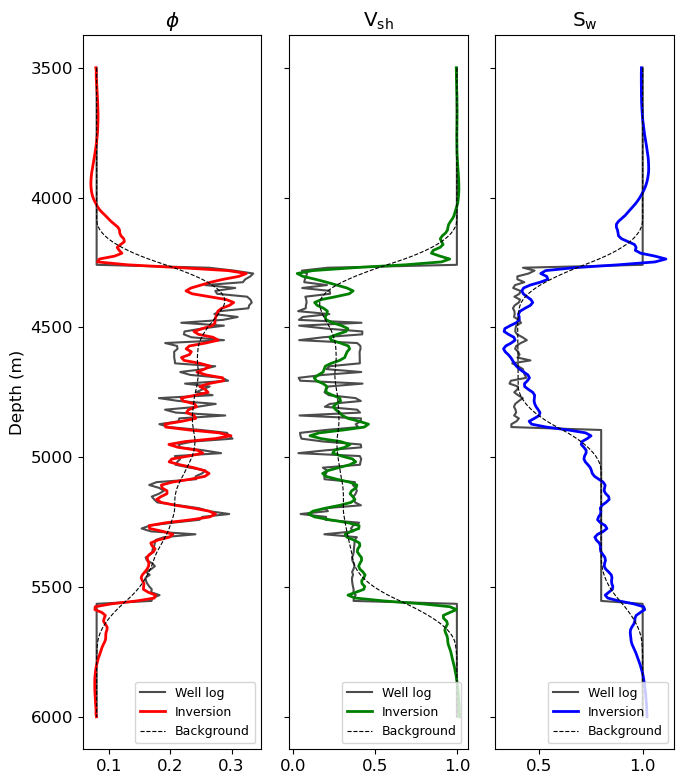

In [19]:
x_loc =100
fig = plot_well_results_2Dsynthethic(depth=depth, well_logs=[phi, vsh, sw], 
                                     inv_dense_reg = [phi_inv_dense_reg, vsh_inv_dense_reg, sw_inv_dense_reg], 
                                     backgrounds = [phi_back, vsh_back, sw_back], x_loc=x_loc)

### Comparing petrophysical coefficients b

To accurately compare the petrophysical reflectivities, we construct our "$\mathrm{B}$" by utilizing the synthetic gather of well logs to obtain the corresponding $\mathrm{Cp}$

In [20]:
m_full = np.stack((phi, vsh, sw),axis=0)
m_back = np.stack((phi_back, vsh_back, sw_back),axis=0)

## To obtain the 'true' B, we need to apply the Poststack operator (wavelet and derivative)
Logsize = len(phi)
kind = 'forward' 
D = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=Logsize, 
                                                  spatdims=Logsize,explicit=True, kind=kind) 

D_A = D.A.copy()

b_full_prof = D_A @ m_full[:,:].T
b_back_prof = D_A @ m_back[:,:].T

b_true = b_full_prof-b_back_prof

## Here we construct the B from the Cp and Hp matrices
b_optAVO_comparison= Cp_estimated.T @ Hp.T @ (b_full_prof-b_back_prof)

Plot the comparison

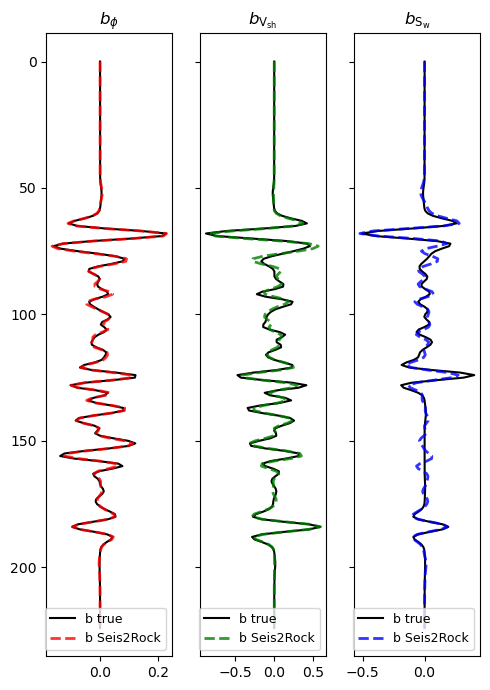

In [21]:
fig = plot_compare_b_reflectivities(b_true=b_true, b_optAVO=b_optAVO_comparison, fontsize=10)